<a href="https://colab.research.google.com/github/Tobistor/Credit-Card-Fraud-Detection/blob/main/Credit_Card_Fraud_Project_MLM_predictive_models_(DT_KNN_LogisticR_SVM_RandomForest_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Project

# Import Data

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
RFC_METRIC = 'gini' #metrics used for RandomForestClasifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForestClassifier
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
#Train/validation/test split
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000 #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False
filename = '/content/creditcard.csv' 
cc_data = pd.read_csv(filename)
#check the data
#cc_data.head()
#cc_data.tail()
print("CreditCard data provided has rows:",cc_data.shape[0], "columns:", cc_data.shape[1])

CreditCard data provided has rows: 284807 columns: 31


In [3]:
# Remove duplicates if present
cc_data.drop_duplicates(inplace=True)
print("After removing Duplicates, CreditCard data now has rows:",cc_data.shape[0], "columns:", cc_data.shape[1])

## A glimpse of the data by first 5 rows
cc_data.head()

After removing Duplicates, CreditCard data now has rows: 283726 columns: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Distinguishing Fraud and Non-fraud

In [4]:
fraud = cc_data[cc_data['Class']==1]
normal = cc_data[cc_data['Class']==0]

### To know the count of Fraud and Non-fraud in dataset

In [5]:
print("Fraud:",fraud.shape,"Normal:",normal.shape)

Fraud: (473, 31) Normal: (283253, 31)


### Statistical Exploration of the dataset

In [6]:
fraud.Amount.describe()

count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [7]:
normal.Amount.describe()

count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

### Visual exploration using matplotlib (Histogram Chart)

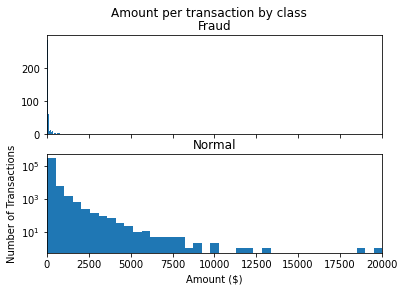

In [8]:
f, (ax1, ax2)=plt.subplots(2,1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

### Visual exploration using matplotlib (Using Scatter plot)

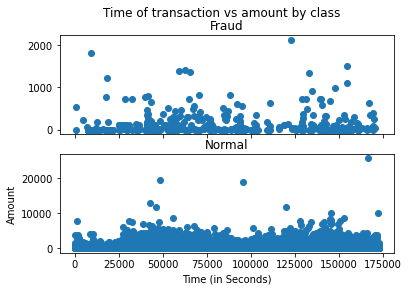

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### Taking 90% of entire data for training

In [10]:
#Take some sample of the data
dataset=cc_data.sample(frac = 0.9,random_state=1)
dataset.shape

(255353, 31)

### Determine the number of fraud and valid transactions in the new dataset

In [11]:
Fraud = dataset[dataset['Class']==1]
Valid = dataset[dataset['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [12]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.001655349878986863
Fraud Cases : 422
Valid Cases : 254931


### Exploration using Heatmap to determine correlation

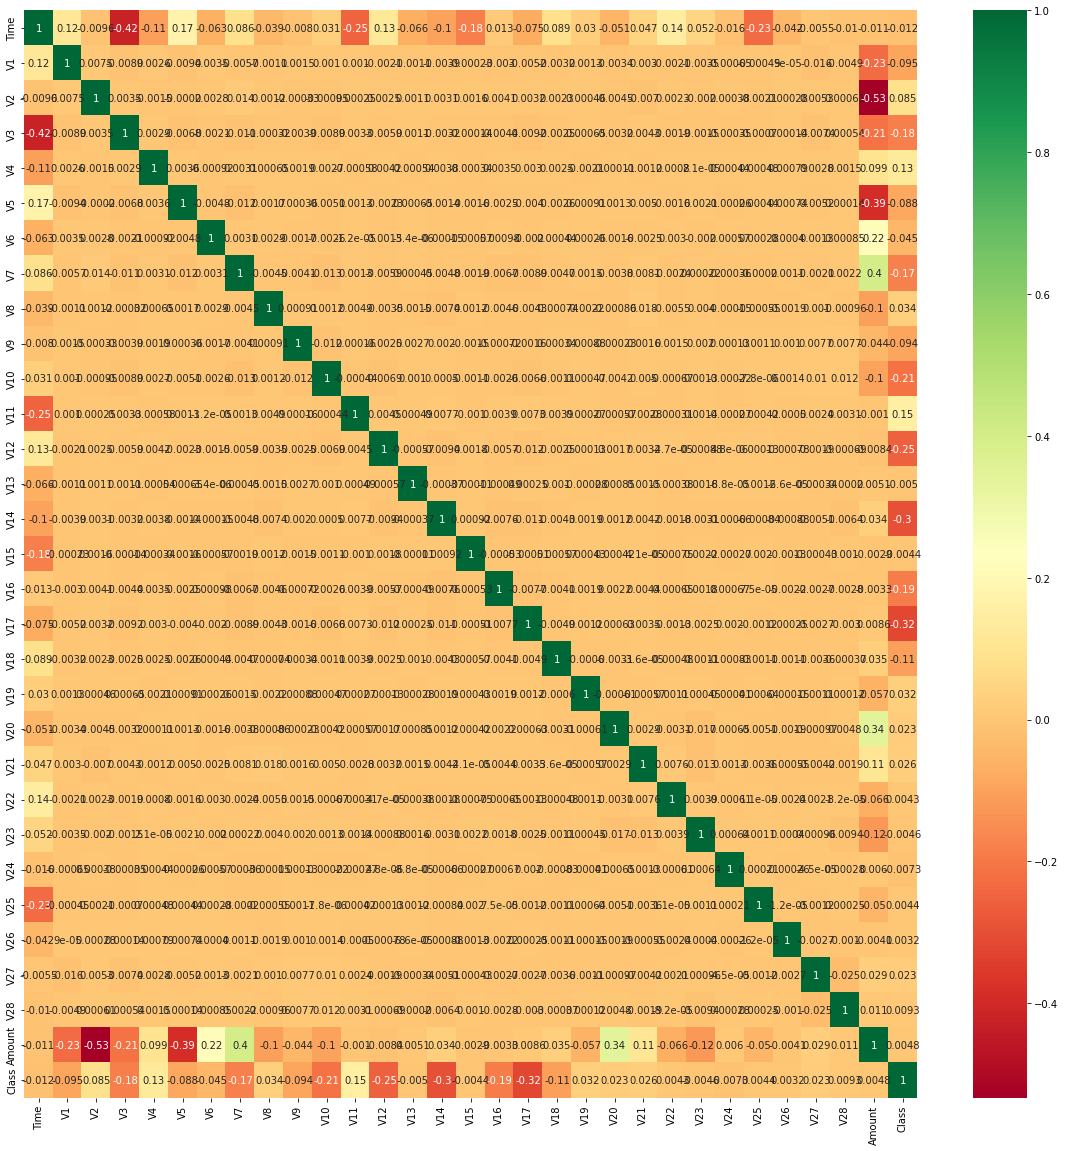

In [13]:
#Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Define X and Y; Data and Target.

In [14]:
#Build model with all of the data features
target = dataset ['Class']
predictors = dataset [['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
             'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
             'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
             'Amount']]

X = predictors #didn't apply .value cos it's already in Numpy array
y = target  #didn't apply .value cos it's already in Numpy array

#Another quick way to create X and y Datasets...
#X = dataset.drop('Class', axis = 1).values
#y = dataset['Class'].values

# Split Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
# Two datasets have now been created, train data we will be used for training our model and the data which is unseen will be used for testing.


### Buliding Model

In [15]:
# Different Machine Learning Models will be tried one by one.

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Accuracy of Logistic Regression model.
print('Accuracy score of the Logistic Regression model is {}'.format(accuracy_score(y_test, lr_pred)))

# Check F1-Score for the Logistic Regression model.
print('F1 score of the Logistic Regression model is {}'.format(f1_score(y_test, lr_pred)))

Accuracy score of the Logistic Regression model is 0.9988721627845047
F1 score of the Logistic Regression model is 0.6210526315789473


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
# K-Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors = 6)
KNN.fit(X_train, y_train)
knn_pred = KNN.predict(X_test)

# Accuracy of K-Nearest Neighbors model.
print('Accuracy score of the K-Nearest Neighbors model is {}'.format(accuracy_score(y_test, knn_pred)))

# Check F1-Score for the K-Nearest Neighbors model.
print('F1 score of the K-Nearest Neighbors model is {}'.format(f1_score(y_test, knn_pred)))

Accuracy score of the K-Nearest Neighbors model is 0.9985745390748602
F1 score of the K-Nearest Neighbors model is 0.0


In [17]:
# Random Forest
RF = RandomForestClassifier(max_depth = 4)
RF.fit(X_train, y_train)
RF_pred = RF.predict(X_test)

# Accuracy of Random Forest model.
print('Accuracy score of the Random Forest model is {}'.format(accuracy_score(y_test, RF_pred)))

# Check F1-Score for the Random Forest model.
print('F1 score of the Random Forest model is {}'.format(f1_score(y_test, RF_pred)))

Accuracy score of the Random Forest model is 0.9993577593633985
F1 score of the Random Forest model is 0.7515151515151516


In [19]:
# XGBoost
XGB = XGBClassifier(max_depth = 4)
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)

# Accuracy of XGBoost model.
print('Accuracy score of the XGBoost model is {}'.format(accuracy_score(y_test, XGB_pred)))

# Check F1-Score for the XGBoost model.
print('F1 score of the XGBoost model is {}'.format(f1_score(y_test, XGB_pred)))

Accuracy score of the XGBoost model is 0.9995144034211062
F1 score of the XGBoost model is 0.8121212121212122


In [20]:
# Decision Tree
DT = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
DT.fit(X_train, y_train)
DT_pred = DT.predict(X_test)

# Accuracy of Decision Tree
print('Accuracy score of the Decision Tree model is {}'.format(accuracy_score(y_test, DT_pred)))

#Check F1-Score for the Decision Tree
print('F1 score of the Decision Tree model is {}'.format(f1_score(y_test, DT_pred)))

#See what the confusion matrix looks like
confusion_matrix(y_test, DT_pred, labels = [0, 1])

#Here, the first row represents positive and the second row represents negative. 
#So, we have 63731 as true positive and 17 are false positive. That says, out of 63731+17=63748, 
#we have 63731 that are successfully classified as a normal transaction and 17 were falsely classified as normal, 
#but they were fraudulent.

Accuracy score of the Decision Tree model is 0.9993420949576278
F1 score of the Decision Tree model is 0.7586206896551725


array([[63731,    17],
       [   25,    66]])